In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sympy import *


Consecutive blocks if MORE THAN CHANCE
Consecutive blocks if PAID MORE

GAS FEE VS. MEV FEE??


Questions:
What can be done with Multi-block MEV? Taxonomy
Q2: How likely, often?
Q3: How cheap is a relay block?
Q6: Profit of MEV blocks over time and count

ToDo: a) take a look at Relayer
b) add block_reward for block without MEV boost

### cleaning

In [ ]:
df_b = pd.read_csv('data/BBRs_5538500_5538999.csv')


In [2]:
df_p = pd.read_csv('data/custom_ppds_output.csv')
df_p

,slot,block_hash,block_reward,gas_used,validator_pubkey,operator_name,pool_name,buidler_pubkey,buidler_name,relay_name,relay_url
0,4700567,0x7d57a1d26f71724737f5dc780ca2dfb778c2fc5be29b...,0.283204,27657346,0xa606aca2180226fc69e0652134eca4c7f4a428585c11...,NaN,NaN,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
1,4700575,0xc923337f63a0ed51288b1468064085679383d41ebee7...,0.845802,27535785,0x9489e9354f515580f6a949f69eed311eeb26b268b744...,NaN,NaN,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
2,4700606,0x804f376a4e15f62a75f26828b8866a0db1cfb2bf9235...,0.213524,24830670,0x82d5ebc6c3ef5eda41dcbb1cbdfd5863ab6e4d16b137...,NaN,NaN,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,flashbots,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
3,4700694,0x4ac8e0a2c04382ed4cdafd44e8f45b77a071a5974d78...,0.113136,23574818,0x8e7d5eed0f72cd56e547e2fabea19a65668577fd2d64...,NaN,NaN,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
4,4700724,0x43a4d4a888f1d2626a4c18f13ed0701f057606396a40...,0.637987,22578328,0xae1426c22c5c0d91d62c5a224759f44569a0a52e6cb8...,NaN,Rocketpool,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
...,...,...,...,...,...,...,...,...,...,...,...
659653,5586752,0xad1be4394d52d6f848baa216ccfac0b250cd51f5a4a2...,0.045863,25229702,0xa7b4840468fbd50602db4cf35a56af9ea11fffac41b5...,Kiln,Lido,0x9000009807ed12c1f08bf4e81c6da3ba8e3fc3d95389...,blocknative,Blocknative,https://0x9000009807ed12c1f08bf4e81c6da3ba8e3f...
659654,5586753,0xff6dbe03e2510fa1430e12a2f2746f4ffc440ea8f1d2...,0.015468,13140362,0x89fd95e3bb0da3d02ca91285c334a1b57f2e22547fef...,Kiln,Lido,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
659655,5586755,0xadd1f3c9daf25e57a49f34ce8aa9acd51816395cc194...,0.024059,10850676,0xad529b90e01cb5de1dfb8d169d4cfc2d8c9b8e46a63c...,NaN,NaN,0x96a59d355b1f65e270b29981dd113625732539e955a1...,beaverbuild.org,Flashbots,https://0xac6e77dfe25ecd6110b8e780608cce0dab71...
659656,5586756,0xc40a53538433179f7ca5f3f884784ed3df677ce90d15...,0.037238,29994005,0xa3c5cc8aedb1d6d50e370ebae6e61ff15552ab9633f1...,Staked.us,NaN,0x84b02bdb674a28dea0467d3dded2b4aad11c0c5dba79...,Unknown,Ultra Sound Relay,https://0xa1559ace749633b997cb3fdacffb890aeebd...


In [3]:
df_p.sort_values(by='slot', ascending=True, inplace=True)

In [4]:
df_p.drop_duplicates(subset=['slot'], keep='first', inplace=True)

In [5]:
df_p.reset_index(drop=True, inplace=True)

In [6]:
df_p.rename(columns={'buidler_pubkey': 'builder_pubkey'}, inplace=True)
df_p.rename(columns={'buidler_name': 'builder_name'}, inplace=True)


In [7]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650577 entries, 0 to 650576
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   slot              650577 non-null  int64  
 1   block_hash        650577 non-null  object 
 2   block_reward      650577 non-null  float64
 3   gas_used          650577 non-null  int64  
 4   validator_pubkey  650577 non-null  object 
 5   operator_name     258638 non-null  object 
 6   pool_name         373918 non-null  object 
 7   builder_pubkey    650577 non-null  object 
 8   builder_name      650577 non-null  object 
 9   relay_name        650577 non-null  object 
 10  relay_url         650577 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 54.6+ MB


In [9]:
print(df_p['builder_name'].unique())
df_p = df_p[['slot', 'block_hash', 'block_reward', 'gas_used', 'validator_pubkey', 'builder_pubkey', 'builder_name', 'relay_name']]


['flashbots' 'eden' 'bloxroute' 'Unknown' 'blocknative' 'manifold'
 'builder0x69' 'Ø\x83\x01\x0b\x84geth\x88go1.19.1\x85linux'
 'https://eth-builder.com' 'beaverbuild.org']


In [10]:
df_p['boosted'] = True

In [11]:
slot = np.arange(df_p['slot'].min(), df_p['slot'].max())
df = pd.DataFrame(slot, columns = ['slot'])


In [12]:
df = df.merge(df_p, how='left', on='slot')
df['builder_name'].fillna('No builder', inplace=True)
df['builder_name'].replace('Ø\x83\x01\x0b\x84geth\x88go1.19.1\x85linux', 'coda_geth_linux', inplace=True)


### descriptive statistics

In [14]:
slots_per_hour = 5*60
slots_per_day = 5*60*24

total_slots = len(df)
total_epochs = int(len(df)/32)
total_days = total_slots / slots_per_day

In [17]:
#fltr = 'builder_name'
fltr = 'builder_pubkey'

df['count'] = 1
df['position'] = 1
count = 0
for i in range(0, len(df)):
    check = (df[fltr].iloc[i] == df[fltr].iloc[i-1]) & (df[fltr].iloc[i] != 'Unknown') & (df[fltr].iloc[i] != 'No builder')
    
    if check == True:
        if count == 0:
            count = 2
        else:
            count += 1

    elif (check == False) & (count == 0):
            continue

    elif (check == False) & (count != 0):
        for j in range(1, count+1):
            df['count'].iloc[i-j] = count
            df['position'].iloc[i-j] = count+1-j

        count = 0




/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/3369397790.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'].iloc[i-j] = count
/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/3369397790.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'].iloc[i-j] = count+1-j


In [18]:
#df['block_reward'].fillna((df[df['count'] == 1]['block_reward'].mean()), inplace=True)


df_backup_pubkey = df

In [ ]:
df_backup = df

In [51]:
df = df_backup
df

,slot,block_hash,block_reward,gas_used,validator_pubkey,builder_pubkey,builder_name,relay_name,boosted,count,position
0,4700567,0x7d57a1d26f71724737f5dc780ca2dfb778c2fc5be29b...,0.283204,27657346.0,0xa606aca2180226fc69e0652134eca4c7f4a428585c11...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
8,4700575,0xc923337f63a0ed51288b1468064085679383d41ebee7...,0.845802,27535785.0,0x9489e9354f515580f6a949f69eed311eeb26b268b744...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
39,4700606,0x804f376a4e15f62a75f26828b8866a0db1cfb2bf9235...,0.213524,24830670.0,0x82d5ebc6c3ef5eda41dcbb1cbdfd5863ab6e4d16b137...,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,flashbots,Flashbots,True,1,1
127,4700694,0x4ac8e0a2c04382ed4cdafd44e8f45b77a071a5974d78...,0.113136,23574818.0,0x8e7d5eed0f72cd56e547e2fabea19a65668577fd2d64...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
157,4700724,0x43a4d4a888f1d2626a4c18f13ed0701f057606396a40...,0.637987,22578328.0,0xae1426c22c5c0d91d62c5a224759f44569a0a52e6cb8...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886182,5586749,0xb5bc6d4298ad48cc79f078b9ba31e791c26b848e5488...,0.052920,20769406.0,0xa7452513f9956bf57fafe33f44bbe58ae74ebfb237d1...,0x81babeec8c9f2bb9c329fd8a3b176032fe0ab5f3b92a...,flashbots,Agnostic Boost Relay,True,1,1
886183,5586750,0xefd2caf6762120850246e370e478ab467be61547ca2b...,0.033386,15889095.0,0x99e05528061ae4f409d9fbef3f6f641779dc1bb91743...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,True,1,1
886185,5586752,0xad1be4394d52d6f848baa216ccfac0b250cd51f5a4a2...,0.045863,25229702.0,0xa7b4840468fbd50602db4cf35a56af9ea11fffac41b5...,0x9000009807ed12c1f08bf4e81c6da3ba8e3fc3d95389...,blocknative,Blocknative,True,1,1
886186,5586753,0xff6dbe03e2510fa1430e12a2f2746f4ffc440ea8f1d2...,0.015468,13140362.0,0x89fd95e3bb0da3d02ca91285c334a1b57f2e22547fef...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,True,1,1


In [19]:
df.groupby(df['count']).size()

count
1     795168
2      74184
3      12903
4       2844
5        715
6        234
7         91
8         40
10        10
dtype: int64

In [50]:
stat = df.groupby(df['count']).size().values

temp = df['count'].unique()
temp.sort()

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60/24), 'days we find:')

for i, x in enumerate(temp):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', x, 'consecutive blocks')

print('proposed by the same builder')

In a dataset of 650576 blocks 90 days we find:
559555 instances of 1 consecutive blocks
37092 instances of 2 consecutive blocks
4301 instances of 3 consecutive blocks
711 instances of 4 consecutive blocks
143 instances of 5 consecutive blocks
39 instances of 6 consecutive blocks
13 instances of 7 consecutive blocks
5 instances of 8 consecutive blocks
1 instances of 10 consecutive blocks
proposed by the same builder


In [21]:
print(df['builder_name'].unique())
print(df.groupby(df['builder_name']).size().sort_values(ascending=False))

['flashbots' 'No builder' 'eden' 'bloxroute' 'Unknown' 'blocknative'
 'manifold' 'builder0x69' 'coda_geth_linux' 'https://eth-builder.com'
 'beaverbuild.org']
builder_name
No builder                 235613
flashbots                  186367
builder0x69                135923
bloxroute                  102130
beaverbuild.org             92256
Unknown                     43617
blocknative                 28252
https://eth-builder.com     27259
coda_geth_linux             24362
eden                         7013
manifold                     3397
dtype: int64


In [22]:
lst = list(df['builder_name'].unique())
calc = pd.DataFrame(lst, columns = ['builder_name'])

temp_lst = []
for x in lst:
    temp_lst.append(len(df[df['builder_name'] == x]))

calc['slots'] = temp_lst

calc['share'] = np.round(calc['slots']/len(df),4)

for i in range(1,20+1):
    temp_lst = []
    
    for x in lst:
        temp_lst.append(int(len(df[(df['builder_name'] == x) & (df['count'] == i)])/i))
    
    name = f'k_{i}'
    calc[name] = temp_lst

calc

,builder_name,slots,share,k_1,k_2,k_3,k_4,k_5,k_6,k_7,...,k_11,k_12,k_13,k_14,k_15,k_16,k_17,k_18,k_19,k_20
0,flashbots,186367,0.2103,160619,11174,965,111,11,1,0,...,0,0,0,0,0,0,0,0,0,0
1,No builder,235613,0.2659,235613,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eden,7013,0.0079,6909,52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bloxroute,102130,0.1152,93359,3893,282,27,5,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Unknown,43617,0.0492,42372,571,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,blocknative,28252,0.0319,25307,1246,108,18,9,2,0,...,0,0,0,0,0,0,0,0,0,0
6,manifold,3397,0.0038,3346,24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,builder0x69,135923,0.1534,114099,9015,1035,136,21,3,2,...,0,0,0,0,0,0,0,0,0,0
8,coda_geth_linux,24362,0.0275,21947,1057,84,11,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,https://eth-builder.com,27259,0.0308,23743,1491,156,14,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
calc.iloc[:,0:13]

,builder_name,slots,share,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
0,flashbots,186367,0.2103,160619,11174,965,111,11,1,0,0,0,0
1,No builder,235613,0.2659,235613,0,0,0,0,0,0,0,0,0
2,eden,7013,0.0079,6909,52,0,0,0,0,0,0,0,0
3,bloxroute,102130,0.1152,93359,3893,282,27,5,1,0,0,0,0
4,Unknown,43617,0.0492,42372,571,33,1,0,0,0,0,0,0
5,blocknative,28252,0.0319,25307,1246,108,18,9,2,0,0,0,0
6,manifold,3397,0.0038,3346,24,1,0,0,0,0,0,0,0
7,builder0x69,135923,0.1534,114099,9015,1035,136,21,3,2,1,0,0
8,coda_geth_linux,24362,0.0275,21947,1057,84,11,1,0,0,0,0,0
9,https://eth-builder.com,27259,0.0308,23743,1491,156,14,2,0,0,0,0,0


### plotting descriptive

In [24]:
print(len(df[df['boosted'] != True]), 'blocks without PBS') 
print(len(df[df['boosted'] == True]), 'blocks with PBS')
print(len(df[df['boosted'] == True])/len(df)*100, '%')


235613 blocks without PBS
650576 blocks with PBS
73.41278214918037 %


/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/3355018240.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


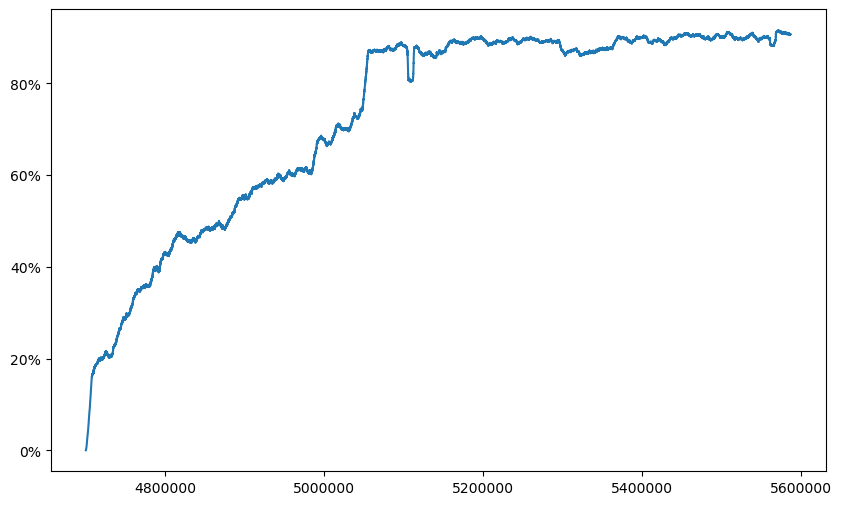

In [27]:
fig, ax = plt.subplots(figsize =(10, 6))

ax.plot(df['slot'], df['boosted'].rolling(slots_per_day, min_periods=1).sum()/slots_per_day)

ax.ticklabel_format(style='plain')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

In [29]:
bins = np.arange(df['slot'].min(), df['slot'].max(), slots_per_day)
data = []
for i in range(0, len(bins)-1):
        data.append(df[(df['slot'] >= bins[i]) & (df['slot'] < bins[i+1])]['block_reward'].mean())

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/117954857.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


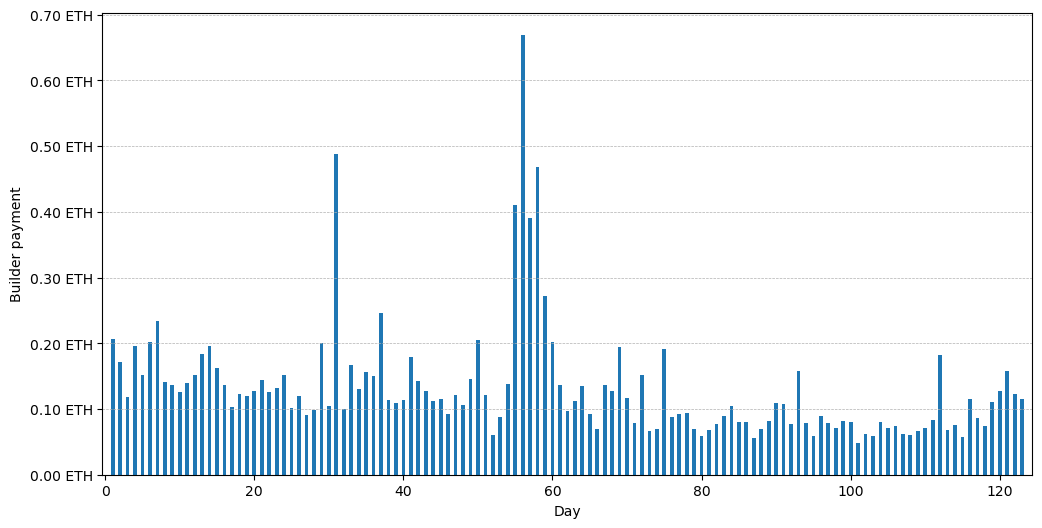

In [30]:
fig, ax = plt.subplots(figsize =(12, 6))

ax.bar(np.arange(1,len(data)+1), data, width = 0.5)
ax.grid(axis='y', linestyle='--', linewidth=.5)

left, right = plt.xlim()
ax.set_xlim(left+5, right-5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Day')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

# show plot
plt.show()

,slot,block_hash,block_reward,gas_used,validator_pubkey,builder_pubkey,builder_name,relay_name,boosted,count,position
0,4700567,0x7d57a1d26f71724737f5dc780ca2dfb778c2fc5be29b...,0.283204,27657346.0,0xa606aca2180226fc69e0652134eca4c7f4a428585c11...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
8,4700575,0xc923337f63a0ed51288b1468064085679383d41ebee7...,0.845802,27535785.0,0x9489e9354f515580f6a949f69eed311eeb26b268b744...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
39,4700606,0x804f376a4e15f62a75f26828b8866a0db1cfb2bf9235...,0.213524,24830670.0,0x82d5ebc6c3ef5eda41dcbb1cbdfd5863ab6e4d16b137...,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,flashbots,Flashbots,True,1,1
127,4700694,0x4ac8e0a2c04382ed4cdafd44e8f45b77a071a5974d78...,0.113136,23574818.0,0x8e7d5eed0f72cd56e547e2fabea19a65668577fd2d64...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
157,4700724,0x43a4d4a888f1d2626a4c18f13ed0701f057606396a40...,0.637987,22578328.0,0xae1426c22c5c0d91d62c5a224759f44569a0a52e6cb8...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,flashbots,Flashbots,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886182,5586749,0xb5bc6d4298ad48cc79f078b9ba31e791c26b848e5488...,0.052920,20769406.0,0xa7452513f9956bf57fafe33f44bbe58ae74ebfb237d1...,0x81babeec8c9f2bb9c329fd8a3b176032fe0ab5f3b92a...,flashbots,Agnostic Boost Relay,True,1,1
886183,5586750,0xefd2caf6762120850246e370e478ab467be61547ca2b...,0.033386,15889095.0,0x99e05528061ae4f409d9fbef3f6f641779dc1bb91743...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,True,1,1
886185,5586752,0xad1be4394d52d6f848baa216ccfac0b250cd51f5a4a2...,0.045863,25229702.0,0xa7b4840468fbd50602db4cf35a56af9ea11fffac41b5...,0x9000009807ed12c1f08bf4e81c6da3ba8e3fc3d95389...,blocknative,Blocknative,True,1,1
886186,5586753,0xff6dbe03e2510fa1430e12a2f2746f4ffc440ea8f1d2...,0.015468,13140362.0,0x89fd95e3bb0da3d02ca91285c334a1b57f2e22547fef...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,builder0x69,Flashbots,True,1,1


### plotting analysis

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/4252048705.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


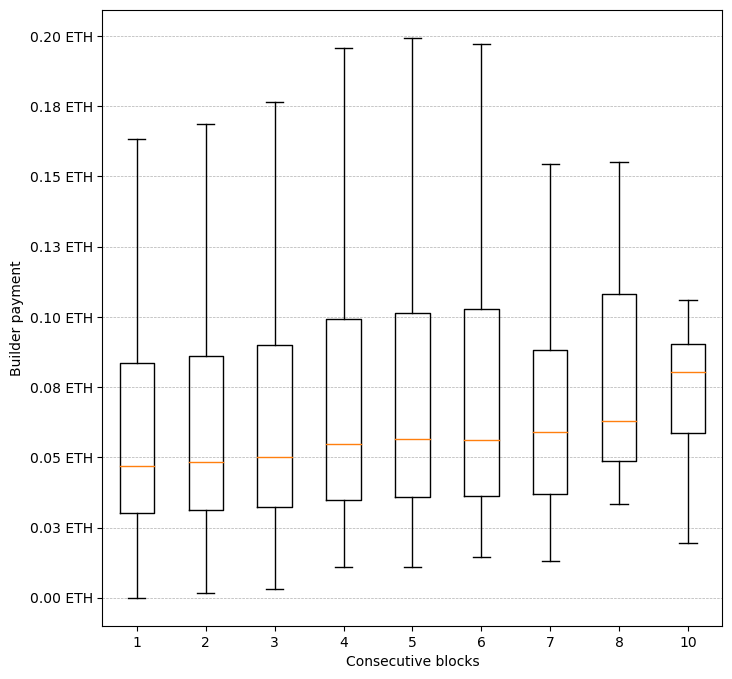

In [53]:
df.dropna(subset=['block_reward'], inplace=True)

temp = df['count'].unique()
temp.sort()

data = []
for x in temp:
    data.append(list(df[df['count']==x]['block_reward']))

fig, ax = plt.subplots(figsize =(8, 8))

ax.boxplot(data, showfliers=False)
ax.grid(axis='y', linestyle='--', linewidth=.5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Consecutive blocks')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(temp)

plt.savefig(f'figures/payment_pubkey.png')
plt.show()


In [54]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [69]:
#exclude without significant data
lst = df[df['count'] >= 9].index

df.drop(lst, inplace=True)

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/3384112509.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])


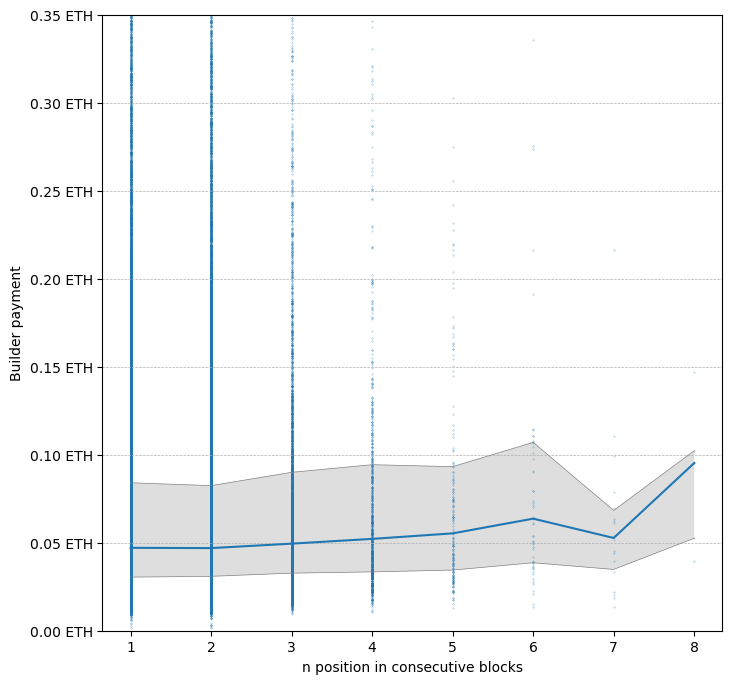

In [74]:
#how much do builder pay on average for consecutive blocks

fig, ax = plt.subplots(figsize =(8, 8))

x = list(df['position'].unique())

ax.plot(x, df['block_reward'].groupby(df['position']).median())
ax.grid(axis='y', linestyle='--', linewidth=.5)


y1 = df.groupby(['position']).agg({'block_reward': [q25]})
y2 = df.groupby(['position']).agg({'block_reward': [q75]})
ax.plot(x, y1, x, y2, color='grey', linewidth=.5)

ax.fill_between(x, list(y1.iloc[:, 0]), list(y2.iloc[:, 0]), facecolor='lightgrey', alpha=.75)


data = df[df['count'] >= 2]
ax.scatter(data['position'], data['block_reward'], s = .05, alpha = .75)

ax.set_ylabel('Builder payment')
ax.set_xlabel('n position in consecutive blocks')

plt.ylim(0, .35)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(list(df['position'].unique()))

plt.savefig(f'figures/payment_position_pubkey.png')

plt.show()


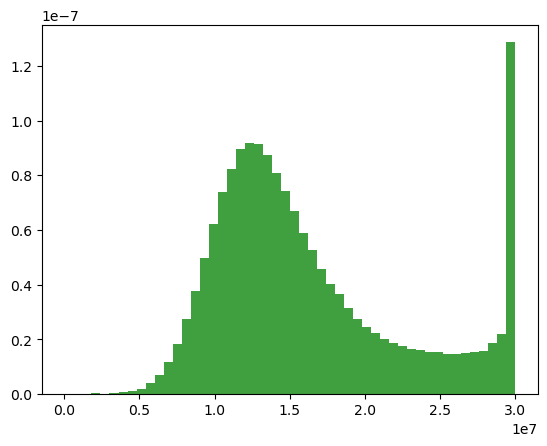

In [102]:
# Is there a pattern, to propose low gas blocks?
# "VALIDATOR for slot k+1 is buying the slot in order to submit an empty block just before the slot they are elected for"
# > Validators could be "unknown"

n, bins, patches = plt.hist(df[df['boosted']==True]['gas_used'], 50, density=True, facecolor='g', alpha=0.75)

temp = df[(df['boosted']==True) & (df['gas_used'] < 0.75e7)]

In [ ]:
temp

In [103]:
print(temp.groupby(['builder_name']).size())

builder_name
Unknown                    1150
beaverbuild.org            1435
blocknative                 269
bloxroute                  2665
builder0x69                2563
coda_geth_linux             479
eden                        196
flashbots                  1412
https://eth-builder.com    3821
manifold                     35
dtype: int64


In [104]:
pd.set_option("display.max_rows", None)
temp.groupby(['builder_name', 'count', 'position']).size().to_frame(name='vals')

vals
builder_name            count position      
Unknown                 1     1         1112
                        2     1           18
                              2           16
                        3     1            3
                              3            1
beaverbuild.org         1     1         1044
                        2     1          130
                              2          150
                        3     1           21
                              2           33
                              3           27
                        4     1            3
                              2            5
                              3            6
                              4            9
                        5     1            1
                              2            3
                        6     3            1
                        7     5            1
                              7            1
blocknative             1     1          227
                        2     1           12
                              2           24
                        3     1            1
                              2            1
                              3            1
                        4     3            1
                              4            2
bloxroute               1     1         2437
                        2     1           95
                              2          109
                        3     1            6
                              2            7
                              3            8
                        4     4            1
                        5     2            1
                              3            1
builder0x69             1     1         2242
                        2     1          103
                              2          160
                        3     1           16
                              2           19
                              3           13
                        4     1            2
                              2            2
                              3            1
                              4            2
                        5     4            1
                              5            1
                        7     6            1
coda_geth_linux         1     1          436
                        2     1           14
                              2           23
                        3     1            1
                              2            2
                              3            3
eden                    1     1          194
                        2     1            2
flashbots               1     1         1250
                        2     1           72
                              2           67
                        3     1            8
                              2            6
                              3            5
                        4     4            2
                        5     2            1
                              5            1
https://eth-builder.com 1     1         3354
                        2     1          257
                              2          134
                        3     1           38
                              2           14
                              3           14
                        4     1            2
                              2            4
                              4            3
                        5     5            1
manifold                1     1           34
                        2     1            1

In [ ]:
B(n,p) =p^5*(1-p)
= (choosen * not chosen)
28 possabilities

P^5*(1-p)*28

P^K*(1-p)^2(32-K-1) + P^K*(1-p)(2)

### math

In [75]:
def prob(c, p):
    # c = consecutive blocks
    # n = slots
    # p = share MEV boost
    
    x = symbols('x', real=True)

    c = c; n = 32; p = p

    xx = min(i for i in solve(1-x+(1-p)*p**c*x**(c+1)) if i > 1)
    qn = ((1 - p*xx) / ((c + 1 - c*xx)*(1-p))) * (1/(xx**(n+1)))
    
    return qn*100, (1-qn)*100

    

In [76]:
calc

,builder_name,slots,share,k_1,k_2,k_3,k_4,k_5,k_6,k_7,...,k_11,k_12,k_13,k_14,k_15,k_16,k_17,k_18,k_19,k_20
0,flashbots,186367,0.2103,160619,11174,965,111,11,1,0,...,0,0,0,0,0,0,0,0,0,0
1,No builder,235613,0.2659,235613,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eden,7013,0.0079,6909,52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bloxroute,102130,0.1152,93359,3893,282,27,5,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Unknown,43617,0.0492,42372,571,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,blocknative,28252,0.0319,25307,1246,108,18,9,2,0,...,0,0,0,0,0,0,0,0,0,0
6,manifold,3397,0.0038,3346,24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,builder0x69,135923,0.1534,114099,9015,1035,136,21,3,2,...,0,0,0,0,0,0,0,0,0,0
8,coda_geth_linux,24362,0.0275,21947,1057,84,11,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,https://eth-builder.com,27259,0.0308,23743,1491,156,14,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
calc[:,0:13]

InvalidIndexError: (slice(None, None, None), slice(0, 13, None))

In [77]:
lst = list(df['builder_name'].unique())
expt = calc[['builder_name', 'slots', 'share']]


In [78]:
lst

['flashbots',
 'eden',
 'bloxroute',
 'Unknown',
 'blocknative',
 'manifold',
 'builder0x69',
 'coda_geth_linux',
 'https://eth-builder.com',
 'beaverbuild.org']

In [97]:
expt

,builder_name,slots,share,e_1
0,flashbots,186367,0.2103,0
1,No builder,235613,0.2659,1
2,eden,7013,0.0079,2
3,bloxroute,102130,0.1152,3
4,Unknown,43617,0.0492,4
5,blocknative,28252,0.0319,5
6,manifold,3397,0.0038,6
7,builder0x69,135923,0.1534,7
8,coda_geth_linux,24362,0.0275,8
9,https://eth-builder.com,27259,0.0308,9


In [93]:
lst

['flashbots',
 'eden',
 'bloxroute',
 'Unknown',
 'blocknative',
 'manifold',
 'builder0x69',
 'coda_geth_linux',
 'https://eth-builder.com',
 'beaverbuild.org']

In [95]:

temp_lst = [0,1,2,3,4,5,6,7,8,9]
temp_lst.append(temp_lst)

expt['e_1'] = temp_lst

for c in range(2,5+1):
    temp_lst = []
    
    for x in lst:
        p = float(expt[expt['builder_name'] == x]['share'].values)
        no_success, success = prob(c, p)
        temp_lst.append(int(np.round(float(success)/100*total_epochs,0)))
    
    name = f'e_{c}'
    expt[name] = temp_lst
    

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_3209/326031712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expt['e_1'] = temp_lst


ValueError: Length of values (10) does not match length of index (11)

In [ ]:
expt

In [ ]:
calc

In [ ]:
p = np.round(len(df[df['builder_name'] == 'beaverbuild.org'])/1500,4)

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we expect ..')
for i in [1,2,3,4,5]:
    c = i
    no_success, success = prob(c, p)
    print(i, 'consecutive blocks: Probability', np.round(float(success),2), '% - Instances:', np.round(float(success)/100*47,0))

print('.. proposed by the same builder')


In [ ]:
stat = df[df['builder_name'] == 'beaverbuild.org'].groupby(['count']).size().values

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we find ..')

for i, x in enumerate(np.sort(df[df['builder_name'] == 'beaverbuild.org']['count'].unique())):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', i+1, 'consecutive blocks')
    
print('.. proposed by the same builder')

In [ ]:
## MATRIX
cons_blocks = np.arange(2,5+1) #cons_blocks
prob = np.arange(.1,.9+.05,.05)

In [ ]:
lst = []
for p in prob:
    lst_temp = []
    lst_temp.append(x)
    for c in cons_blocks:
        no_success, success = prob(c, p)
        lst_temp.append(success)
    
    for z in range(0, len(lst_temp)):
        try: 
            lst_temp[z] = np.round(float(lst_temp[z]), 2)
        except TypeError:
            lst_temp[z] = 100
        
    lst.append(lst_temp)
        

In [ ]:
df = pd.DataFrame(lst, columns =['probability', 'k=2', 'k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
df = df.set_index('probability')
df

In [ ]:
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*225, 'k=5 consecutive blocks a day.')
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*6759, 'k=5 consecutive blocks a month.')
